In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
from sklearn.decomposition import PCA
from shapely.geometry import LineString, Point
from folium.plugins import Fullscreen, MiniMap
import geoplot as gplt
from shapely import wkt
from mpl_toolkits.mplot3d import Axes3D

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Data Preparation
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Load the data


In [38]:
file_path = "./data/"

# load the spatial feature map as a geodataframe
spatial_features = gpd.read_file(f'{file_path}census_spatial_features.geojson', crs='epsg:4326')

In [68]:
# load the taxi trips
taxi_df = pd.read_csv(f'{file_path}clean_taxi_data.csv')

# drop rides with no dropoff location 
taxi_df = taxi_df[taxi_df.dropoff_location.notna()]


# Get a random subset of 100k rows rows, overwrite the variable  with the 14M rows
taxi_df = taxi_df.sample(n=100000, random_state=12).reset_index()

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Format the data for the clustering


In [69]:
spatial_features['census'] = spatial_features.census.astype('int')

In [70]:
# drop  columns that will not be needed for the clustering
taxi_df = taxi_df.drop(columns=['index', 'Unnamed: 0', 'taxi_id','trip_seconds', 'trip_miles', 'fare',
                                'start_day', 'end_day','start_time', 'end_time'])

In [71]:
def map_spatial_features(taxi_df, spatial_features, feature_name, pickup_col, dropoff_col):
    '''Helper function that maps the spatial features to the taxi trips
    Inputs: spatial features geodataframe, taxi trips dataframe ,the spatial feature column name,
            the columns of the pickup and dropoff census tracts
    Outputs: None --> all operations are performed inplace in that taxi trips dataframe'''
    
    # Create a map of census tracts to the specified feature
    feature_map = spatial_features.set_index('census')[feature_name]
    
    # Map census tracts to the feature for pickup and dropoff
    taxi_df[f'pickup_{feature_name}'] = taxi_df[pickup_col].map(feature_map)
    taxi_df[f'dropoff_{feature_name}'] = taxi_df[dropoff_col].map(feature_map)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Map the spatial to each ride


In [72]:
# apply the function to incorporate all the spatial features
map_spatial_features(taxi_df, spatial_features, 'dist_centre', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'min_dist_airport', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_hotels', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_bars', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'num_stadiums', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'airport_in_census', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_resid', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_commerc', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_transport', 'pickup_census', 'dropoff_census')
map_spatial_features(taxi_df, spatial_features, 'perc_open', 'pickup_census', 'dropoff_census')


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Format the spatial features / create temporal features


In [73]:
### format the features ###
#extract the latitude and longitude from the pickup and dropoff locations
taxi_df[['lat_pickup', 'long_pick']] = taxi_df['pickup_location'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')
taxi_df[['lat_dropoff', 'long_dropoff']] = taxi_df['dropoff_location'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')

# convert the  string to time objects
taxi_df['trip_start'] = pd.to_datetime(taxi_df['trip_start'])
taxi_df['trip_end'] = pd.to_datetime(taxi_df['trip_end'])

# extract the hours
taxi_df['pickup_hour'] = taxi_df['trip_start'].dt.hour
taxi_df['dropoff_hour'] = taxi_df['trip_end'].dt.hour

# extract whether the ride was on a weekend
taxi_df['pickup_weekend'] =  taxi_df['trip_start'].dt.weekday.isin([5, 6]).astype(int)
taxi_df['dropoff_weekend'] =  taxi_df['trip_end'].dt.weekday.isin([5, 6]).astype(int)

### create expressive hourly resolutions ###
# morning commuting 
taxi_df['pickup_morning_commuting'] = taxi_df['pickup_hour'].apply(lambda x: 1 if 6 <= x <= 10 else 0)
taxi_df['dropoff_morning_commuting'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if 6 <= x <= 10 else 0)

# Morning commuting on weekdays (1 if weekend = 0 and morning commuting = 1). 
# We overwrite the morning commuting variables created above, as only morning commuting on weekdays is irrelevant from our POV.

taxi_df['pickup_morning_commuting'] = taxi_df['pickup_morning_commuting'] * (1 - taxi_df['pickup_weekend'])
taxi_df['dropoff_morning_commuting'] = taxi_df['dropoff_morning_commuting'] * (1 - taxi_df['dropoff_weekend'])

# afternoon commuting
taxi_df['pickup_afternoon_commuting'] = taxi_df['pickup_hour'].apply(lambda x: 1 if 14 <= x <= 18 else 0)
taxi_df['dropoff_afternoon_commuting'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if 14 <= x <= 18 else 0)

# Afternoon commuting on weekdays (1 if weekend = 0 and afternoon commuting = 1). 
# We overwrite the afternoon commuting variables created above, as only afternoon commuting on weekdays is irrelevant from our POV.
taxi_df['pickup_afternoon_commuting'] = taxi_df['pickup_afternoon_commuting'] * (1 - taxi_df['pickup_weekend'])
taxi_df['dropoff_afternoon_commuting'] = taxi_df['dropoff_afternoon_commuting'] * (1 - taxi_df['dropoff_weekend'])


# bar hours
taxi_df['pickup_bar_hours'] = taxi_df['pickup_hour'].apply(lambda x: 1 if (20 <= x <= 23 or 0 <= x <= 4) else 0)
taxi_df['dropoff_bar_hours'] = taxi_df['dropoff_hour'].apply(lambda x: 1 if (20 <= x <= 23 or 0 <= x <= 4) else 0)


# drop the features that are not needed anymore
taxi_df = taxi_df.drop(columns=['pickup_location', 'dropoff_location', 'pickup_census', 'dropoff_census',\
                               'trip_end', 'trip_start'])

Due to the circularity of time, we do not include the hour variable. We argue that it does not add any additional explanatory power, as we already have 3 discrete expressive hourly resolution (morning- and afternoon commuting and bar hours). When each of the 3 binary variables is 0, the time of the trip was either 11,12,13,19 or 5. We need not create an additional discrete variable for these residual hours and we cannot think of expressive hourly resolutions for these either.

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Scaling of the data
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

We include all the spatial features and the 4 binary temporal features (morning and afternoon commuting, bar hours and weekend) for the pickup location and time, as well as the dropoff location and time. This allows us to cluster actual trips, rather than just ride demand (pickups) or taxi supply (dropoff). This leaves us with 32 total features to be included in the cluster analysis. We use the standard scaler to scale the features.

In [74]:
# features to be scaled and included in the clustering
features = ['pickup_dist_centre', 'dropoff_dist_centre', 'pickup_min_dist_airport',
       'dropoff_min_dist_airport', 'pickup_num_hotels', 'dropoff_num_hotels',
       'pickup_num_bars', 'dropoff_num_bars', 'pickup_num_stadiums',
       'dropoff_num_stadiums', 'pickup_airport_in_census',
       'dropoff_airport_in_census', 'pickup_perc_resid', 'dropoff_perc_resid',
       'pickup_perc_commerc', 'dropoff_perc_commerc', 'pickup_perc_transport',
       'dropoff_perc_transport', 'pickup_perc_open', 'dropoff_perc_open',
       'lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff',
       'pickup_morning_commuting', 'dropoff_morning_commuting',
       'pickup_afternoon_commuting', 'dropoff_afternoon_commuting',
       'pickup_bar_hours', 'dropoff_bar_hours', 'pickup_weekend', 'dropoff_weekend']

# scale the rides with the standard scaler
rides_scaled = StandardScaler().fit_transform(taxi_df[features])

In [75]:
# display the shape of the scaled feature vector
rides_scaled.shape

(100000, 32)

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        PCA Analysis
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Determine the optimal number of principal components


As our features are highly correlated and similar, we perform Principal Component Analysis to reduce the dimensionality of the feature vector. This allows us to  better identify and model the underlying distribution of the data, leading to more accurate and interpretable cluster assignments. We will use the principal components for both the soft clustering with gaussian mixtures models and the hard clustering with K-Means. We choose the number of principal component that explain at least 90% of the variance. In this case 14 components for a sample size of 100,000 trips.

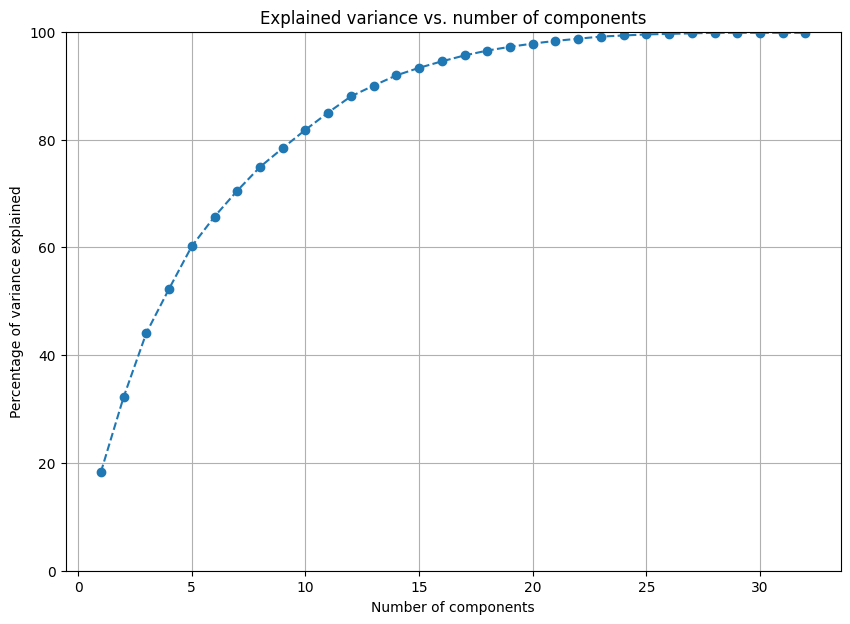

In [76]:
# Create a plot that shows how much of the variance is explained by adding additional components
pca = PCA()
pca.fit(rides_scaled)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

plt.figure(figsize = (10,7))
plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
plt.grid()
plt.ylim(0,100)


plt.ylabel("Percentage of variance explained")
plt.xlabel("Number of components")
plt.title("Explained variance vs. number of components")
plt.show()

In [77]:
# get cumulative variance from the PCA analysis
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Determine the number of components that explain at least 90% of the variance
optimal_components = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= 0.90) + 1
print(f'The optimal number of principal components is {optimal_components}.')

The optimal number of principal components is 14.


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Fit the principal components (n_components=14)


In [78]:
# choose number of components according to the previous analysis
pca = PCA(n_components = 14)

# Fit the model on the scaled rides
pca.fit(rides_scaled)
scores_pca = pca.transform(rides_scaled)

# Inspect the PCA components
components = pca.components_

# Create a DataFrame for better readability of the features
pca_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(components.shape[0])])
print("PCA Components:")
print(pca_df)

PCA Components:
      pickup_dist_centre  dropoff_dist_centre  pickup_min_dist_airport  \
PC1             0.348989             0.238366                -0.279559   
PC2            -0.190715             0.339669                 0.208477   
PC3            -0.049646             0.019336                 0.193914   
PC4             0.028272             0.014059                 0.000591   
PC5             0.023264             0.023963                 0.119078   
PC6            -0.025113            -0.038836                 0.034533   
PC7            -0.025211            -0.076754                -0.150718   
PC8            -0.067754            -0.016493                 0.007800   
PC9             0.039070            -0.008264                 0.032933   
PC10            0.014671             0.030971                -0.128836   
PC11           -0.007368             0.009607                -0.050647   
PC12            0.060189             0.048265                 0.099147   
PC13           -0.0173

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Soft clustering with Gaussian Mixture Models
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

The most important hyperparameter in cluster analysis is the number of clusters. However, to determine the optimal number of clusters for GMM, we would have to fit the model many times and calculate the silhouette scores or related metric, which is too computationally expensive for our machines. Therefore, we create an elbow plot using the bayesian information criterion (BIC) as the metric on the y-axis and the number of clusters on the x-axis. We then fit the model 14 times for the different numbers of clusters in the range (1,14). This will at least give as a range in which the optimal of number most likely lies.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create an ellbow plot to determine the range for the optimal number of clusters


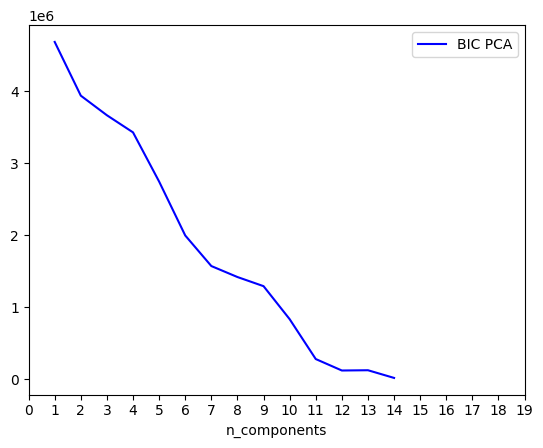

In [66]:
# Use the ellbow method to determine a range for the optimal number of clusters
n_components = np.arange(1, 15)
models1 = [GaussianMixture(n, covariance_type='full', random_state=0).fit(scores_pca)
          for n in n_components]

# plot the bayesian information criterion for the different number of clusters
plt.plot(n_components, [m1.bic(scores_pca) for m1 in models1], label='BIC PCA', color='blue')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(range(0, 20, 1));

<div class="alert alert-block alert-warning">
<b>Note:</b> The ellbow plot is only sufficient for determining the range of the optimal number of clusters. Other methods like silhouette score may be used to determine the optimal number of clusters. However, calculating the silhouette scores for GMM with a sample of 100k rides already took more than 25 minutes. For this reason, we refrain from including this further analysis here and choose the number of cluster in the ellbow, in this case 11 clusters. 
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Fit the GMM with 11 clusters and the PCA features


In [79]:
# Apply Gaussian Mixture Model with n_components=11 and the PCA features
gmm = GaussianMixture(covariance_type = 'full',n_components = 11, random_state = 0)  
gmm.fit(scores_pca)
labels = gmm.predict(scores_pca)
# create a new dataframe with all the features 
gmm_df = taxi_df[[*features]].copy()

# add the cluster labels to the new dataframe
gmm_df['cluster'] = labels.astype(str)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Modify some variables to then calculate the cluster centroids (descriptive analytics)


In [80]:
# convert the gps coordinates and the cluster label to float/int
gmm_df['lat_pickup'] = gmm_df['lat_pickup'].astype(float)
gmm_df['long_pick'] = gmm_df['long_pick'].astype(float)
gmm_df['lat_dropoff'] = gmm_df['lat_dropoff'].astype(float)
gmm_df['long_dropoff'] = gmm_df['long_dropoff'].astype(float)
gmm_df['cluster'] = gmm_df['cluster'].astype(int)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create shapely geometries for each trip (for visualization)


In [81]:
def create_geometry(row):
    ''' Function to create LineString for the pickup and dropoff coordinate or a buffered Point (Polygon)
    if start and end coordinates are equal'''
    
    if (row['lat_pickup'], row['long_pick']) == (row['lat_dropoff'], row['long_dropoff']):
        # Create a small buffer around the point to make it visible as a circle
        # this will automatically create a polygon
        return Point(row['long_pick'], row['lat_pickup']).buffer(0.001)
        
    else:
        return LineString([(row['long_pick'], row['lat_pickup']), (row['long_dropoff'], row['lat_dropoff'])])

In [82]:
# Aggregate the data by pickup and dropoff coordinates and cluster and count their occurence
agg_gmm = gmm_df.groupby(['lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff', 'cluster']).size().reset_index(name='count')


# Apply the function created in the cell above to create the geometry for all trips
agg_gmm['geometry'] = agg_gmm.apply(create_geometry, axis=1)

# Convert to a GeoDataFrame
gmm_gdf = gpd.GeoDataFrame(agg_gmm, geometry='geometry', crs='epsg:4326')

In [83]:
# take a look at geodataframe
gmm_gdf.head()

,lat_pickup,long_pick,lat_dropoff,long_dropoff,cluster,count,geometry
0,-87.90304,41.979071,-87.903040,41.979071,5,758,"POLYGON ((41.98007 -87.90304, 41.98007 -87.903..."
1,-87.90304,41.979071,-87.901886,42.005560,2,2,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
2,-87.90304,41.979071,-87.901886,42.005560,3,4,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
3,-87.90304,41.979071,-87.844359,41.975338,2,2,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."
4,-87.90304,41.979071,-87.844359,41.975338,3,6,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculate the centroid for each cluster


We calculate the centroid for each cluster as well as the centroid for the entire sample. This will come in handy for labeling the clusters later.

In [84]:
# calculate the centroid for each cluster
gmm_cluster_centroids = gmm_df[[*features,'cluster']].groupby('cluster').mean(numeric_only = True)


# calculate the centroid for the entire sample 
overall_centroid = gmm_df[[*features,'cluster']].mean(numeric_only = True).to_frame().T

# create a dataframe with each cluster and the entire dataframe as columns
gmm_centroid_df = pd.concat([gmm_cluster_centroids, overall_centroid], ignore_index=False).T

# rename the columns
gmm_centroid_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
              'cluster 6', 'cluster 7', 'cluster 8', 'cluster 9', 'cluster 10', 'entire data']

# drop the cluster row
gmm_centroid_df = gmm_centroid_df.drop(index='cluster', errors='ignore')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the number of rides in each cluster


In [85]:
gmm_gdf.groupby('cluster')['count'].sum().reset_index()

,cluster,count
0,0,11327
1,1,15998
2,2,6820
3,3,5320
4,4,11244
5,5,4217
6,6,12485
7,7,9759
8,8,7716
9,9,10463


We can oberve that while the clusters do not contain equal numbers of trips there are also no clusters with signficantly lower or higher rides. Keep that in mind for the comparison with the K-Means clustering.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Visualize the Principal components and the clusters


As we have 14 principal components, there is no point in creating pairplots or picking out some combinations of components to visualize the results.
Instead, we create a 3D plot with PCA1, PCA2 and PCA3, which are the most important components. While it not possible to precisely interpret the components, we can still observe that the clustering algorithm worked. That is, even when only considering 3 out of 14 components, we can clearly see separation between most, albeit not all, clusters. To better visualize the clustered trips, we then create a spatial visualization with a toggle bar to select/unselect some or all clusters.

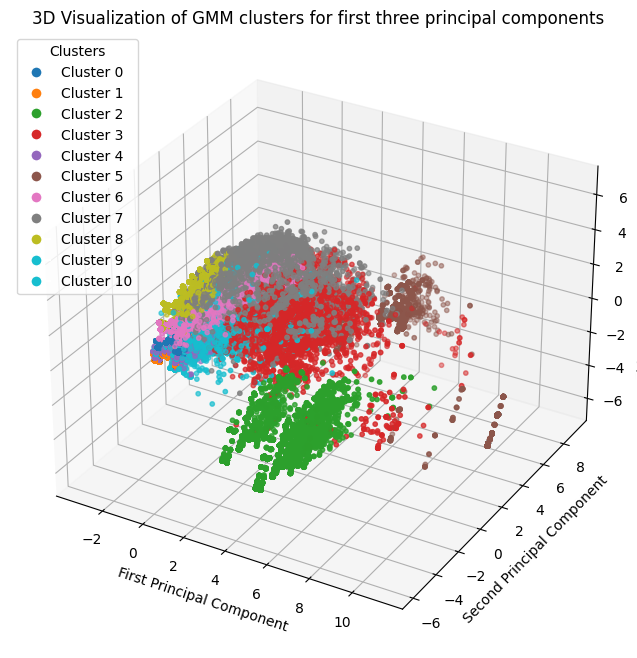

In [86]:
# scores_pca contains the scores that resulted from the PCA conducted earlier in  the notebook
# we use the first 3 PCA components
X_pca = scores_pca[:, :3]  
# we predict the labels for the first three principal components
labels = gmm.predict(scores_pca)  

# Initialise the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA components, coloring by cluster
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab10', s=10)

# Labeling the axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Create a customized legend for the clusters
unique_labels = np.unique(labels)
# add the clusters with the  corresponding colors to the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.cmap(sc.norm(i)), markersize=8) 
           for i in unique_labels]

ax.legend(handles, [f'Cluster {i}' for i in unique_labels], title='Clusters', loc='upper left', bbox_to_anchor=(0, 1))

plt.title('3D Visualization of GMM clusters for first three principal components')
plt.show()

We can observe that some clusters i.e. cluster 2, cluster 8 can be seperated quite well, while most clusters can not be clearly distinguished with only 3 componnents.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create a spatial visualization for all trips in each cluster


<div class='alert alert-danger'>
    <b>IMPORTANT:</b> This code cell creates a folium map with the clustered trips. Unfortunetely, the notebook would be too large (for github) to run it directly here. Therefore, we have uploaded the folium as a HTML file to github. Alternatively, you can execute the cell and run 'm' in a different cell to display the folium map.    
</div>

In [87]:
# Initialize a folium map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

''' Iterate over each cluster and create a separate layer for each,
this allows us to filter the clusters in the folium map'''

for cluster in range(len(gmm_gdf['cluster'].unique())):
    
    # Filter the GeoDataFrame for the current cluster and make a copy
    cluster_gdf = gmm_gdf[gmm_gdf['cluster'] == cluster].copy()

    # Calculate scaling factors based on the max count in the cluster
    max_count = cluster_gdf['count'].max()

    # Ensure the scaling is not too extreme by adding a small constant
    line_weight_scale = max_count / 10 if max_count > 0 else 1
    stroke_weight_scale = max_count / 10 if max_count > 0 else 1
    fill_opacity_scale = max_count / 100 if max_count > 0 else 0.1

    # Define a feature group/layer for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')

    # Add tooltips displaying the cluster and count
    for _, row in cluster_gdf.iterrows():
        tooltip_text = f"cluster: {cluster}, num_rides: {row['count']}"

        # trips that occured only once should be highlighted
        if row['count'] == 1:
            color = 'red'
        # very common trips should be highlighted
        elif row['count'] >= np.percentile(gmm_gdf['count'], 99.9):
            color = 'blue'
        else:
            color = 'green' if row['geometry'].geom_type == 'LineString' else 'green'

        # trips that occured more often should have higher line weights/ opacity
        line_weight = max(1, row['count'] / line_weight_scale)
        fill_opacity = min(1, row['count'] / fill_opacity_scale)
        stroke_weight = max(1, row['count'] / stroke_weight_scale)

        # add the lines with the formatting to the folium map
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(locations=[(coord[0], coord[1]) for coord in row['geometry'].coords],
                            color=color, weight=line_weight,  tooltip=tooltip_text).add_to(fg)

        # add the polygons with the formatting to the folium map
        elif row['geometry'].geom_type == 'Polygon':
            folium.Polygon(locations=[(coord[0], coord[1]) for coord in row['geometry'].exterior.coords],
                           color='black', fill=True, fill_opacity=fill_opacity, weight=stroke_weight,
                           tooltip=tooltip_text).add_to(fg)

    # Add the feature group/layer to the map
    fg.add_to(m)

# Add layer control to select specific clusters
folium.LayerControl().add_to(m)


# Add a fullscreen button
fullscreen = Fullscreen(position="topright")
m.add_child(fullscreen)

# Add a minimap to the map
minimap = MiniMap(toggle_display=True, position="bottomleft")
m.add_child(minimap)

m.save('gmm_clustered_trips.html')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Label the clusters


In [88]:
# show the cluster centroids (descriptive data)
gmm_centroid_df

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,entire data
pickup_dist_centre,374.914894,338.914427,22182.313196,12192.561090,789.779260,5232.723500,1501.745935,4711.847730,538.697382,3282.040046,1916.036766,3689.033690
dropoff_dist_centre,661.108678,735.439367,1307.588416,9522.955639,445.877624,22276.395305,2754.893152,5142.219080,539.732504,4526.556341,2266.023651,3244.297890
pickup_min_dist_airport,15117.275889,15109.540880,439.398827,11122.030827,15200.424315,12241.455537,15544.599039,15149.453325,15381.796008,15284.104941,14549.556654,13858.488620
dropoff_min_dist_airport,15143.978812,15165.447368,15491.250147,13751.723120,14903.740039,442.594261,15894.595755,15731.502715,15412.885951,15726.513333,14017.715760,14630.427370
pickup_num_hotels,10.879050,11.854857,0.000000,0.659398,8.014586,8.179274,7.929355,3.021928,9.078409,3.600019,6.770157,7.086900
dropoff_num_hotels,9.206498,8.376422,8.408798,0.383271,10.972163,0.000000,4.821866,1.508454,9.653318,3.438306,2.998065,6.203720
pickup_num_bars,7.378035,8.146018,0.188270,1.265414,5.340181,5.091060,6.886824,3.833180,7.709824,3.597343,5.544829,5.497280
dropoff_num_bars,7.238457,6.718527,6.362317,1.548496,7.925916,0.179749,5.129996,2.793934,7.818559,3.540954,4.742636,5.417280
pickup_num_stadiums,0.000000,0.000000,0.000000,0.000000,0.000000,0.049561,0.000000,0.000000,0.047175,0.092039,0.244034,0.026710
dropoff_num_stadiums,0.000000,0.000000,0.042522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755536,0.038040


<h2>Labeling of the GMM clusters</h2>

<p>We label the clusters by analysing the cluster centroids and confirming/rejecting the hypothesis by looking at the folium map. To also view the folium map you can either run m in a code cell or download the html file called 'gmm_clustered_trips.html' from our github rep. Please select each  cluster individually.</p>

<ul>
    <li><strong>Cluster 0:</strong> As all binary temporal variables have an average value of 0, these trips are entirely made up of rides during the week between the 11th-14th or 5th or the 19th hour. Additionally, the rides started close to the centre and ended a bit further from the centre. We would label these trips as <b>Intra-center trips outside of rush-hours</b>.</li> Looking at the map, we observe that the rides all originated (or ended) in  the city centre.
    <li><strong>Cluster 1:</strong> All trips in this cluster occured during afternoon commuting hours on weekdays. They additionally started close to the city and ended further from the centre. We label the trips in this cluster as <b>Intra-center afternoon commuting</b>.</li> Looking at the map, we observe that the rides all originated (or ended) in  the city centre.
    <li><strong>Cluster 2:</strong> All trips in this cluster started in census tracts with an airport inside. They happened at unspecific hours and days. We label the trips in this cluster as <b>Pickup from airport</b>.</li> Looking at the map, we observe that the rides all originated at the 2 airports and many of them ended in the city centre.
        <li><strong>Cluster 3:</strong> The trips in this cluster started an ended in census tracts with high a share of residential land use. On the folium map, we can observe that most of the trips occured only once (i.e. they are visualized by red lines). The trips also happened during unspecific time slots. This could be people visiting people in other areas of the city. We label the trips in this cluster as <b>Unspecific rides between residential areas</b>.</li> 
        <li><strong>Cluster 4:</strong> All trips in this cluster started during morning commuting hours on weekdays. They also ended closer to the city than they started. We label the trips in this cluster as <b>Intra-center morning commuting</b>.</li> This hypothesis can be confirmed by looking at cluster 4 in the folium map.
                <li><strong>Cluster 5:</strong> All trips in this cluster ended in census tracts with airports. We label the trips in this cluster as <b>Dropoff at airport</b>.</li> This hypothesis can also be confirmed by looking at cluster 5 in the folium map, because all lines connect to the 2 airports.
                <li><strong>Cluster 6:</strong> All trips in this cluster ended during bar hours on weekdays. These rides may be explained by some people driving home from their night shift or some people who were at bars or clubs. We label the trips in this cluster as <b>Night shift- maybe?</b>.</li> Looking at the map, we can see that these rides do not follow any spatial pattern, making it even harder to label this particular cluster.
                                <li><strong>Cluster 7:</strong> All trips in this cluster occured during the weekend, some of which during bar hours. The trips mostly took connected residential areas We label the trips in this cluster as <b>Too drunk to drive</b>.</li> 
                <li><strong>Cluster 8:</strong> All trips in this cluster occured during the weekend, some of which during bar hours. The trips mostly took connected census tracts in the city centre. We label the trips in this cluster as <b>Tourists and drunk people</b>.</li>  We can observe that all rides happened close to the city center. Many rides even took place in a single census tract.
                <li><strong>Cluster 9:</strong> The rides mostly happened during afternoon commuting hours and they are quite unspecific. Most trips were sporadic indicated by the red lines. These trips can not be labeled precisely with our features.
                <li><strong>Cluster 10:</strong> The rides in this clusters are even more unspecific than the ones in cluster 9. Thus, these must definitely be residual rides.

<p>Some of the clusters can be labeled quite easily by looking at the centroids and plotting the specific trips of the cluster on the folium map, however some clusters can not be labeled with this approach. This may be due to the fact that we did not choose the optimal number of clusters or the fact that some rides can not be labeled.</p>

<h2>Identifying specific customer types</h2>

<p>By plotting the trips and looking at the cluster centroids, we can clearly identify two customer types. First, there are travelers (tourists and business travelers) that use taxis to ride from and to the 2 airports , mainly from and to the city centre. Second, there are commuters, most likely business people, using taxis to get from A to B during the rush hours. There may also be other customer types like party people / drunk people, but since the trips were censored to census tract resolution, the POI data cannot be used effectively to label the clusters and thus we have too few features to identify more specific types of trips or customers.</p>


<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Hard clustering with KMeans
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create an ellbow plot to determine the range for the optimal number of clusters


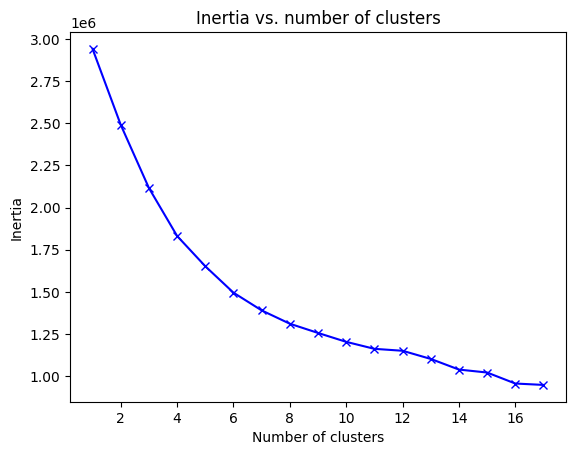

In [50]:
# Use the ellbow method to determine a range for the optimal number of clusters

# init an empty list for the within-cluster sum of squares (inertia) for each number of clusters
inertia = []

# iterate over the number of clusters and calculate the inertia for each model
for n in range(1, 18):
    kmeans = KMeans(n_clusters = n, n_init=10, random_state = 0).fit(scores_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,18), inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. number of clusters')
plt.show()

We observe that the range for the optimal number of clusters according to the ellbow method is [5,17]. We decide to use 11 clusters, as calculating the silhouette scores or other methods to determine the optimal number of clusters takes more than 20 minutes on our machines. Additionally, we chose 11 clusters as well in the soft clustering part. Thus, we can perfectly compare the results of KMeans and GMM, as both share the same principal components and number of clusters.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Fit the GMM with 11 clusters and the PCA features


In [51]:
# Apply Kmeans clustering with n_clusters=11 and the PCA features
kmeans = KMeans(n_clusters = 11, n_init=10, random_state = 0).fit(scores_pca)  
kmeans.fit(scores_pca)
labels2 = kmeans.predict(scores_pca)

# create a new dataframe with all the features 
kmeans_df = taxi_df[[*features]].copy()

# add the cluster labels to the new dataframe
kmeans_df['cluster'] = labels2.astype(str)


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Modify some variables to then calculate the cluster centroids (descriptive analytics)


In [52]:
# convert the gps coordinates and the cluster label to float/int
kmeans_df['lat_pickup'] = kmeans_df['lat_pickup'].astype(float)
kmeans_df['long_pick'] = kmeans_df['long_pick'].astype(float)
kmeans_df['lat_dropoff'] = kmeans_df['lat_dropoff'].astype(float)
kmeans_df['long_dropoff'] = kmeans_df['long_dropoff'].astype(float)
kmeans_df['cluster'] = kmeans_df['cluster'].astype(int)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create shapely geometries for each trip (for visualization)


In [53]:
# Aggregate the data by pickup and dropoff coordinates and cluster and count their occurence
agg_kmeans = kmeans_df.groupby(['lat_pickup', 'long_pick', 'lat_dropoff', 'long_dropoff', 'cluster']).size().reset_index(name='count')


# Apply the create_geometry function to create the geometry for all trips
agg_kmeans['geometry'] = agg_kmeans.apply(create_geometry, axis=1)

# Convert to a GeoDataFrame
kmeans_gdf = gpd.GeoDataFrame(agg_kmeans, geometry='geometry', crs='epsg:4326')

In [54]:
# take a look at geodataframe
kmeans_gdf.head()

,lat_pickup,long_pick,lat_dropoff,long_dropoff,cluster,count,geometry
0,-87.90304,41.979071,-87.903040,41.979071,9,758,"POLYGON ((41.98007 -87.90304, 41.98007 -87.903..."
1,-87.90304,41.979071,-87.901886,42.005560,9,6,"LINESTRING (41.97907 -87.90304, 42.00556 -87.9..."
2,-87.90304,41.979071,-87.844359,41.975338,6,8,"LINESTRING (41.97907 -87.90304, 41.97534 -87.8..."
3,-87.90304,41.979071,-87.844090,41.972105,6,3,"LINESTRING (41.97907 -87.90304, 41.97210 -87.8..."
4,-87.90304,41.979071,-87.841586,41.982273,6,28,"LINESTRING (41.97907 -87.90304, 41.98227 -87.8..."


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Calculate the centroid for each cluster


In [55]:
# calculate the centroid for each cluster
kmeans_cluster_centroids = kmeans_df[[*features,'cluster']].groupby('cluster').mean(numeric_only = True)


# calculate the centroid for the entire sample 
overall_centroid2 = kmeans_df[[*features,'cluster']].mean(numeric_only = True).to_frame().T

# create a dataframe with each cluster and the entire dataframe as columns
kmeans_centroid_df = pd.concat([kmeans_cluster_centroids, overall_centroid2], ignore_index=False).T

# rename the columns
kmeans_centroid_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
              'cluster 6', 'cluster 7', 'cluster 8', 'cluster 9', 'cluster 10', 'entire data']

# drop the cluster row
kmeans_centroid_df = kmeans_centroid_df.drop(index='cluster', errors='ignore')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get the number of rides in each cluster

In [56]:
kmeans_gdf.groupby('cluster')['count'].sum().reset_index()

,cluster,count
0,0,11237
1,1,4976
2,2,3428
3,3,10346
4,4,19984
5,5,13252
6,6,7001
7,7,13684
8,8,12799
9,9,865


We can see that, unlike in the soft clustering with GMM, one of the K-means clusters has very few trips, while cluster 4 has almost 20% of the total trips. This might mean that K-means has a harder time accurately assigning trips to clusters, especially when the data isn’t evenly spread out or when the clusters overlap. K-means forces each trip into just one cluster, which can lead to imbalances and less meaningful groupings. On the other hand, GMM is more flexible because it allows each trip to belong to multiple clusters to different degrees, which helps create more balanced and accurate clusters. 

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Visualize the Principal components and the clusters


As we have 14 principal components, again, there is no point in creating pairplots or picking out some combinations of components to visualize the results. This is the same as in the case of the soft clustering with GMM. Instead, we create a 3D plot with PCA1, PCA2 and PCA3, which are the most important components. While it not possible to precisely interpret the components, we can still observe that the clustering algorithm worked. That is, even when only considering 3 out of 14 components, we can clearly see separation between most, albeit not all, clusters. To better visualize the clustered trips, we then create a spatial visualization with a toggle bar to select/unselect some or all clusters.

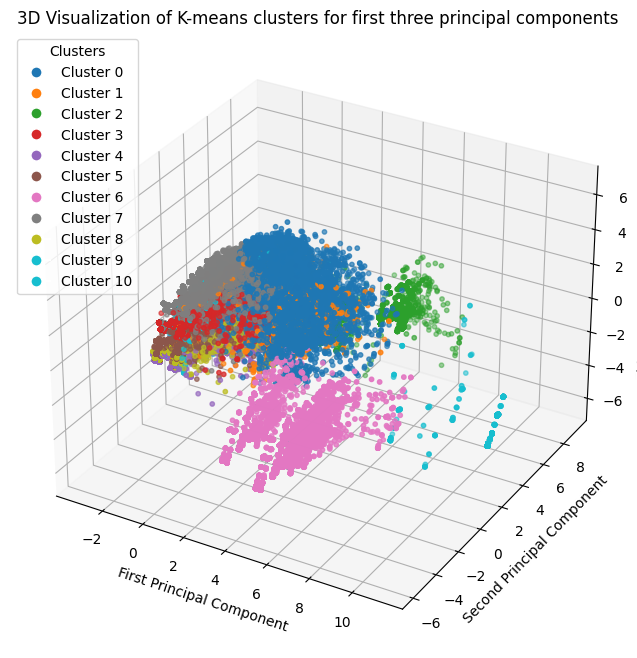

In [57]:
# scores_pca contains the scores that resulted from the PCA conducted earlier in  the notebook
# we use the first 3 PCA components
X_pca = scores_pca[:, :3]  
# we predict the labels for the first three principal components
labels2 = kmeans.predict(scores_pca)  

# Initialise the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA components, coloring by cluster
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels2, cmap='tab10', s=10)

# Labeling the axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Create a customized legend for the clusters
unique_labels = np.unique(labels2)
# add the clusters with the  corresponding colors to the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.cmap(sc.norm(i)), markersize=8) 
           for i in unique_labels]

ax.legend(handles, [f'Cluster {i}' for i in unique_labels], title='Clusters', loc='upper left', bbox_to_anchor=(0, 1))

plt.title('3D Visualization of K-means clusters for first three principal components')
plt.show()

We can observe that only plotting 3 principal components of the clusters for Kmeans is insufficient to identify clearly seperable clusters. Each of  clusters are in proximity to each other and their points overlap. To identify clear clusters, we visualize the trips in a spatial map to see whether we can identify clusters along the spatial dimensions.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create a spatial visualization for all trips in each cluster (Kmeans)


<div class='alert alert-danger'>
    <b>IMPORTANT:</b> This code cell creates a folium map with the clustered trips. Unfortunetely, the notebook would be too large (for github) to run it directly here. Therefore, we have uploaded the folium as a HTML file to github. Alternatively, you can execute the cell and run 'm' in a different cell to display the folium map.    
</div>

In [58]:
# Initialize a folium map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

''' Iterate over each cluster and create a separate layer for each,
this allows us to filter the clusters in the folium map'''

for cluster in range(len(kmeans_gdf['cluster'].unique())):
    
    # Filter the GeoDataFrame for the current cluster and make a copy
    cluster_gdf = kmeans_gdf[kmeans_gdf['cluster'] == cluster].copy()

    # Calculate scaling factors based on the max count in the cluster
    max_count = cluster_gdf['count'].max()

    # Ensure the scaling is not too extreme by adding a small constant
    line_weight_scale = max_count / 10 if max_count > 0 else 1
    stroke_weight_scale = max_count / 10 if max_count > 0 else 1
    fill_opacity_scale = max_count / 100 if max_count > 0 else 0.1

    # Define a feature group/layer for this cluster
    fg = folium.FeatureGroup(name=f'Cluster {cluster}')

    # Add tooltips displaying the cluster and count
    for _, row in cluster_gdf.iterrows():
        tooltip_text = f"cluster: {cluster}, num_rides: {row['count']}"

        # trips that occured only once should be highlighted
        if row['count'] == 1:
            color = 'red'
        # very common trips should be highlighted
        elif row['count'] >= np.percentile(kmeans_gdf['count'], 99.9):
            color = 'blue'
        else:
            color = 'green' if row['geometry'].geom_type == 'LineString' else 'green'

        # trips that occured more often should have higher line weights/ opacity
        line_weight = max(1, row['count'] / line_weight_scale)
        fill_opacity = min(1, row['count'] / fill_opacity_scale)
        stroke_weight = max(1, row['count'] / stroke_weight_scale)

        # add the lines with the formatting to the folium map
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(locations=[(coord[0], coord[1]) for coord in row['geometry'].coords],
                            color=color, weight=line_weight,  tooltip=tooltip_text).add_to(fg)

        # add the polygons with the formatting to the folium map
        elif row['geometry'].geom_type == 'Polygon':
            folium.Polygon(locations=[(coord[0], coord[1]) for coord in row['geometry'].exterior.coords],
                           color='black', fill=True, fill_opacity=fill_opacity, weight=stroke_weight,
                           tooltip=tooltip_text).add_to(fg)

    # Add the feature group/layer to the map
    fg.add_to(m)

# Add layer control to select specific clusters
folium.LayerControl().add_to(m)


# Add a fullscreen button
fullscreen = Fullscreen(position="topright")
m.add_child(fullscreen)

# Add a minimap to the map
minimap = MiniMap(toggle_display=True, position="bottomleft")
m.add_child(minimap)

m.save('k-means_clustered_trips.html')



<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Compare soft clustering with hard clustering
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [89]:
# display the cluster centroids for KMeans
kmeans_centroid_df

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,entire data
pickup_dist_centre,8930.677494,2549.596463,823.757293,1086.478542,751.095727,698.304784,22227.056563,1465.793628,1329.767169,23374.763006,1905.177924,3689.033690
dropoff_dist_centre,8563.964403,3470.979100,21987.663944,2043.381790,1341.174440,1019.717326,1537.686188,1869.310289,990.976014,23554.467052,1932.440692,3244.297890
pickup_min_dist_airport,15109.296787,14327.068127,15113.753792,15021.131645,14954.040282,14994.184048,467.062420,15309.608594,15071.816392,546.634682,13948.745470,13858.488620
dropoff_min_dist_airport,16668.521936,15382.832195,451.036173,15318.733907,15053.377552,14958.407788,15376.510070,15225.931087,14685.015704,523.501734,14701.548600,14630.427370
pickup_num_hotels,0.428584,4.398312,10.093057,9.289774,10.662380,10.592288,0.011284,7.165376,7.345730,0.016185,2.334843,7.086900
dropoff_num_hotels,0.235205,4.139469,0.007876,5.424802,7.285779,8.725777,8.223397,5.933937,9.699586,0.016185,6.925453,6.203720
pickup_num_bars,1.710777,2.164188,6.281797,8.005509,7.551291,7.279128,0.196829,6.614513,4.958278,0.099422,5.177100,5.497280
dropoff_num_bars,1.743615,3.980908,0.214702,5.624783,6.091523,7.057803,6.243537,5.794943,7.252051,0.082081,5.038715,5.417280
pickup_num_stadiums,0.000178,0.000000,0.060968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.013180,0.026710
dropoff_num_stadiums,0.009967,0.071342,0.000000,0.036826,0.033026,0.040899,0.042565,0.048012,0.045004,0.000000,0.091845,0.038040


<h2>Shortfalls of KMeans</h2>

<p>By looking at the cluster centroids and looking at the folium maps, we can observe that KMeans struggles to clearly seperate the trips with high-dimensional feature vector(compared to GMM . This can also be observed in the 3D PCA plot. KMeans is clearly not flexible enough when clusters have different shapes and sizes, which is clearly the case for the taxi trip dataset. Unlike Kmeans, GMM was able (for the same PCA features, sample size and number of clusters) to clearly separate all trips to and from airports. Kmeans also included trips to the census tracts next to the airports in these clusters. This because apparent when filtering the clusters 2,6,9 in the folium map for the Kmeans clusters (called 'k-means_clustered_trips.html' in our github rep). Furthermore, Kmeans did not catch all the rides for specific discrete time intervals i.e. the commuting hours, unlike GMM which managed to it. For this reasons, there is no point in trying to label the clusters for the KMeans clustering, as it was already difficult to do so for the GMM where the  centroids were much more expressive and some cluster can be identified on a 2D spatial map. Thus, overall GMM did a much better job than KMeans, albeit it did not perfectly cluster the trips such that they can easily and perfectly labeled. </p>




<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Identify spatial Hotspots
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Draw a new random sample for the identification of the hotspots


In [59]:
# load the taxi trips
taxi_df = pd.read_csv('clean_taxi_data.csv')

# drop rides with no dropoff location 
taxi_df = taxi_df[taxi_df.dropoff_location.notna()]

# Get a random subset of 100k rows rows, overwrite the variable  with the 14M rows
taxi_df = taxi_df.sample(n=250000, random_state=12).reset_index()

# convert the location to shapely points
taxi_df.pickup_location = taxi_df.pickup_location.apply(wkt.loads)
taxi_df.dropoff_location = taxi_df.dropoff_location.apply(wkt.loads)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Create seperate geodataframes for pickup and dropoff locations 


In [60]:
gdf1 = gpd.GeoDataFrame(taxi_df, geometry = 'pickup_location', crs = 'epsg:4326')
gdf2 = gpd.GeoDataFrame(taxi_df, geometry = 'dropoff_location', crs = 'epsg:4326')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Import the city boundaries and the airport locations


In [61]:
# load the census tract data
census = gpd.read_file('Boundaries.geojson', crs = 'epsg:4326')
# load the POI data 
POI = gpd.read_file('POI_data.geojson', crs = 'epsg:4326')

In [62]:
# filter the airports to later include them in the KDE plot
airports = POI[POI.Category == 'Airport']


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Use kernel density estimation to identify spatial hotspots for taxi demand (pickup locations)


We create a plot of the Chicago area to visualize taxi pickup density and highlight potential spatial hotspots. We plot the boundaries of the dissolved census tracts as a base map. On top of this base map, a Kernel Density Estimation (KDE) plot is overlaid to show the density of taxi pickups across the city, using a red colormap to indicate areas with higher taxi demand. This KDE plot helps identify spatial hotspots, which are regions with concentrated taxi activity. Additionally, the locations of two airports are plotted to potentially label these hotspots, as airports are typically corellated with high taxi demand. KDE is particularly useful in identifying spatial hotspots because it smoothes the distribution of points across the map, highlighting areas with higher concentrations of activity. 

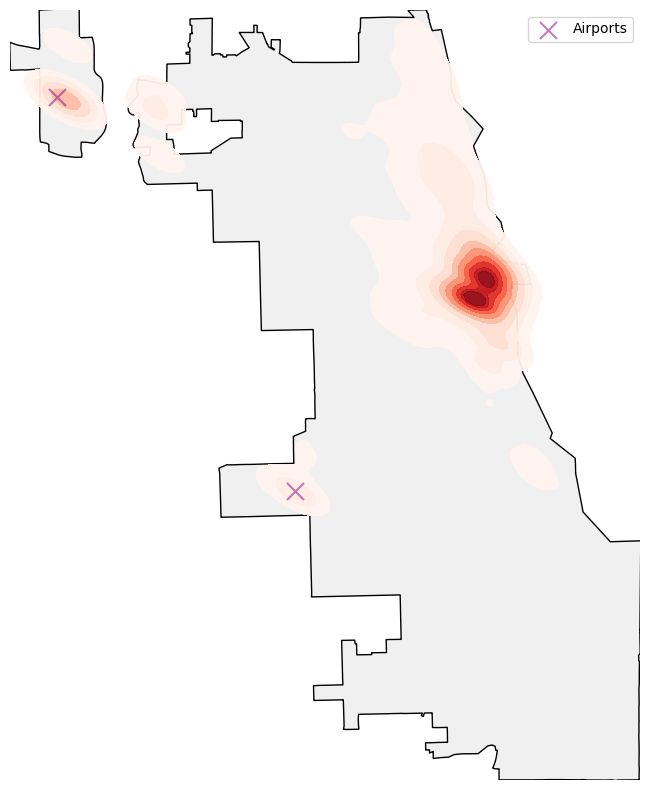

In [63]:
# Define the extent for the Chicago area
chicago_extent = (-87.94011, -87.52413, 41.64454, 42.02304)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the dissolved census tracts with the boundary
census.dissolve().plot(ax = ax, linewidth = 1, color='#F0F0F0', edgecolor = 'black')

# Overlay the (gaussian) KDE plot for the taxi pickups
gplt.kdeplot(gdf1, ax = ax, cmap = "Reds", fill = True, extent=chicago_extent, alpha = 0.95)

# plot the 2 airports  to potentially  label the spatial hotspots
airports.plot(ax = ax, marker = 'x', color = 'purple', markersize = 150,  label = 'Airports', alpha = 0.5)

# set the geographic boundaries of the chicago area
ax.set_xlim(chicago_extent[0], chicago_extent[1])
ax.set_ylim(chicago_extent[2], chicago_extent[3])


# Add a legend
ax.legend()


# Show the  plot
plt.show()

We can easily identify two spatial hotspots with the kernel density estimation. The main hotspot with the darkest shade of red is in the middle of chicago. In fact, it is where the city centre, also called Chicago Loop, is located. Additionally, the areas around the hotspot also show lighter shades of red, compared to the south of chicago, where apparently no hotspots are. The second hotspot is in the north west of chicago. It is where the airport chicago o'hare is located, as indicated by the purple cross. However, this hotspot seems to smaller in size and lower in magnitude (lighter shade of red compared to the hotspot in the centre). One may argue that there is even a third hotspot located in the middle west of chicago, where the chicago midway airport is located. However, the light shade of red indicates that this is most likely no hotspot, at least not in the comparatively small sample we used to fit the kernel density estimation plot.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Use kernel density estimation to identify spatial hotspots for taxi supply (dropoff locations)


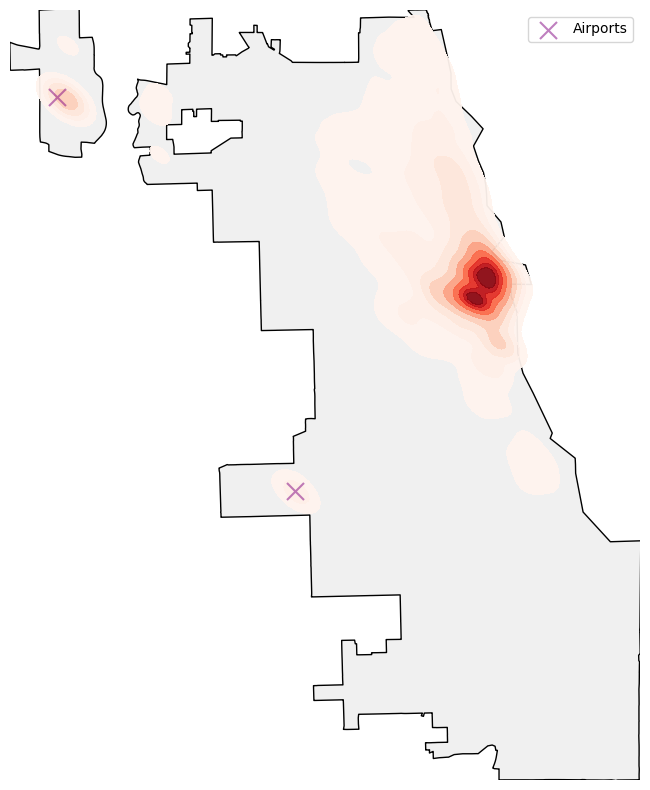

In [64]:
# Define the extent for the Chicago area
chicago_extent = (-87.94011, -87.52413, 41.64454, 42.02304)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the dissolved census tracts with the boundary
census.dissolve().plot(ax = ax, linewidth = 1, color='#F0F0F0', edgecolor = 'black')

# Overlay the KDE plot for the taxi dropoffs
gplt.kdeplot(gdf2, ax = ax, cmap = "Reds", fill = True, extent=chicago_extent, alpha = 0.95, thresh=0.05)

# plot the 2 airports  to potentially  label the spatial hotspots
airports.plot(ax = ax, marker = 'x', color = 'purple', markersize = 150,  label = 'Airports', alpha = 0.5)

# set the geographic boundaries of the chicago area
ax.set_xlim(chicago_extent[0], chicago_extent[1])
ax.set_ylim(chicago_extent[2], chicago_extent[3])


# Add a legend
ax.legend()


# Show the  plot
plt.show()

We observe that the two hotspots identified in the kde_plot for the taxi demand also exists for the taxi supply. There is one large hotspot in the city centre and a smaller one at the airport chicago o'hare. The hotspots differ slightly in the size, implying that even more rides are directed to inbound the center than there are outbound rides. There does not seem to be an actual hotspot for dropoffs at airport chicago midway.